<a href="https://colab.research.google.com/github/Jeremy26/hydranets_course/blob/main/MTL_Run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the Extended HydraNet Workshop 🐸🐸🐸
In this workshop, you're going to learn how to add a new head to our pretrained network.
* Input: **a monocular RGB Image**
* Output: **a Depth Map**, **a Segmentation Map** and **Another Depth Map**

A single model with three different outputs. For that we'll need to use transfer learning to keep the pretrained weights and set up the optimizer to only train the new weights in order to save compute cycles. There are many different ways to transfer the weights, the approach we're going to take here constructs the two headed model and loads the weights before making changes to the architecture and forward function.

# 1 - Initialize Environment

In [ ]:
!wget https://hydranets-data.s3.eu-west-3.amazonaws.com/hydranets-data-2.zip && unzip -q hydranets-data-2.zip && mv hydranets-data-2/* . && rm hydranets-data-2.zip && rm -rf hydranets-data-2

Set up the development environment if needed.

```
conda create --name hydranet python=3.8 pytorch torchvision torchaudio pytorch-cuda cudatoolkit -c pytorch -c nvidia -c conda-forge -y
conda activate hydranet
pip install opencv-python matplotlib ipykernel tqdm notebook prefetch_generator albumentations timm==0.6.13 efficientnet_pytorch
```
```
conda create -n hydranet python=3.8 -y
conda activate hydranet
conda install cudatoolkit=11.1.1 -c conda-forge
pip install torch torchvision torchaudio
pip install opencv-python matplotlib tqdm

```

Import all the necessary libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as co
from PIL import Image
import numpy as np
import cv2
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable
import glob
import os

/home/brian/miniconda3/envs/hydranet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2 - The Transfer Learning Technique
Before we jump in and start modifying the hydranet let's use a simple model to take a quick look at the technique we'll be using to add the new head.

## 2.1 - Create a Simple Model
To illustrate the approach let's create a simple model on the cpu with a single 3x3 kernel and add some logic that will allow us to extend it. By using the default constructor values and printing out the state dict we can see all nine kernel weghts and the bias for this model.

In [2]:
class Net1(nn.Module):
    def __init__(self, pretrained=None, extend=False):
        super().__init__()
        self.conv1 = nn.Conv2d(1,1,3,1)

        if pretrained:
            self.load_state_dict(torch.load(pretrained))

        if extend:
            self.extend()
            self.forward = self.extended_forward

    def forward(self, x):
        out = self.conv1(x)
        return [out]

    def extend(self):
        self.conv2 = nn.Conv2d(1,1,3,1)
    
    def extended_forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(x)
        return [out1, out2]

net1 = Net1()

print(net1)
print(net1.state_dict())
torch.save(net1.state_dict(), 'Net1.pth')


Net1(
  (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
)
OrderedDict([('conv1.weight', tensor([[[[ 0.1267,  0.3000, -0.0087],
          [ 0.0728, -0.3324,  0.0219],
          [ 0.1361,  0.2012, -0.2798]]]])), ('conv1.bias', tensor([-0.0962]))])


## 2.2 - Extend the Simple Model
Next we'll create another instance of the class but this time initialize it with the previous model and extend it. Notice how another set of weights are added and that the first set matches the weights from our previous network. 

In [3]:
net2 = Net1('Net1.pth', True)
print(net2)
print(net2.state_dict())

Net1(
  (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
)
OrderedDict([('conv1.weight', tensor([[[[ 0.1267,  0.3000, -0.0087],
          [ 0.0728, -0.3324,  0.0219],
          [ 0.1361,  0.2012, -0.2798]]]])), ('conv1.bias', tensor([-0.0962])), ('conv2.weight', tensor([[[[-0.1757,  0.0332,  0.2273],
          [ 0.1856, -0.3175,  0.2669],
          [-0.1661, -0.1948, -0.2557]]]])), ('conv2.bias', tensor([-0.0424]))])


## 2.3 - Perform a Training Cycle
Now that we've added a third head we're going to want to train it. The following code performs one training cycle with random inputs and outputs. Notice how only the conv2 parameters are passed to the optimizer, this will prevent the weights in conv1 from beign modified which would keep the pretrained weights in that part of the network. You can see how only the conv2 weights have changed when we print out the state dict. Alternatively, we could pass all the parameters to the opitmizer if we wanted to train the entire model. What you want to do will depend on your particular scenario.

In [4]:
test_input = torch.rand((1,1,5,5))
loss_func = nn.MSELoss()#.to(device)
optimizer = torch.optim.SGD(net2.conv2.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)
optimizer.zero_grad()

out = net2(test_input)
gt1 = torch.rand(out[0].shape)
gt2 = torch.rand(out[1].shape)

loss1 = loss_func(out[0], gt1)
loss2 = loss_func(out[1], gt2)
(loss1 + loss2).backward()
optimizer.step()

print(net2.state_dict())
torch.save(net2.state_dict(), 'Net2.pth')

OrderedDict([('conv1.weight', tensor([[[[ 0.1267,  0.3000, -0.0087],
          [ 0.0728, -0.3324,  0.0219],
          [ 0.1361,  0.2012, -0.2798]]]])), ('conv1.bias', tensor([-0.0962])), ('conv2.weight', tensor([[[[-0.1745,  0.0344,  0.2283],
          [ 0.1865, -0.3165,  0.2678],
          [-0.1655, -0.1941, -0.2549]]]])), ('conv2.bias', tensor([-0.0408]))])


## 2.4 - Update the Class
After training the extended model we may want to simplify our class by removing the logic we used to extend it in the first place. After doing that you can see that we can load the saved weights and the architecture is the same as before. 

In [5]:
class Net2(nn.Module):
    def __init__(self, pretrained=None):
        super().__init__()
        self.conv1 = nn.Conv2d(1,1,3,1)
        self.conv2 = nn.Conv2d(1,1,3,1)

        if pretrained:
            self.load_state_dict(torch.load(pretrained))
 
    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(x)
        return [out1, out2]
    
net2 = Net2('Net2.pth')
print(net2)
print(net2.state_dict())

Net2(
  (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
)
OrderedDict([('conv1.weight', tensor([[[[ 0.1267,  0.3000, -0.0087],
          [ 0.0728, -0.3324,  0.0219],
          [ 0.1361,  0.2012, -0.2798]]]])), ('conv1.bias', tensor([-0.0962])), ('conv2.weight', tensor([[[[-0.1745,  0.0344,  0.2283],
          [ 0.1865, -0.3165,  0.2678],
          [-0.1655, -0.1941, -0.2549]]]])), ('conv2.bias', tensor([-0.0408]))])


# 3 - Creating the HydraNet
Create the model in the same way as the previous workshop. Most of the code in this section is from previous modules and is needed to set up our pretrained hydranet. In section 4 we'll add and train the new head.

## 3.1 - Determine the Device

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 3.2 - Create the Encoder
Define all the necessary layers for MobileNet, load the pre-trained weights and freeze them to speed up training.

In [7]:
def conv1x1(in_channels, out_channels, stride=1, groups=1, bias=False,):
    "1x1 Convolution: Pointwise"
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=bias, groups=groups)

def conv3x3(in_channels, out_channels, stride=1, dilation=1, groups=1, bias=False):
    """3x3 Convolution: Depthwise: 
    https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    """
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=bias, groups=groups)

def batchnorm(num_features):
    """
    https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
    """
    return nn.BatchNorm2d(num_features, affine=True, eps=1e-5, momentum=0.1)

def convbnrelu(in_channels, out_channels, kernel_size, stride=1, groups=1, act=True):
    "conv-batchnorm-relu"
    if act:
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=int(kernel_size / 2.), groups=groups, bias=False),
                             batchnorm(out_channels),
                             nn.ReLU6(inplace=True))
    else:
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=int(kernel_size / 2.), groups=groups, bias=False),
                             batchnorm(out_channels))

class InvertedResidualBlock(nn.Module):
    """Inverted Residual Block from https://arxiv.org/abs/1801.04381"""
    def __init__(self, in_planes, out_planes, expansion_factor, stride=1):
        super().__init__() # Python 3
        intermed_planes = in_planes * expansion_factor
        self.residual = (in_planes == out_planes) and (stride == 1) # Boolean/Condition
        self.output = nn.Sequential(convbnrelu(in_planes, intermed_planes, 1),
                                    convbnrelu(intermed_planes, intermed_planes, 3, stride=stride, groups=intermed_planes),
                                    convbnrelu(intermed_planes, out_planes, 1, act=False))

    def forward(self, x):
        #residual = x
        out = self.output(x)
        if self.residual:
            return (out + x)#+residual
        else:
            return out

class MobileNetv2(nn.Module):
    def __init__(self, return_idx=[6]):
        super().__init__()
        # expansion rate, output channels, number of repeats, stride
        self.mobilenet_config = [
        [1, 16, 1, 1],
        [6, 24, 2, 2],
        [6, 32, 3, 2],
        [6, 64, 4, 2],
        [6, 96, 3, 1],
        [6, 160, 3, 2],
        [6, 320, 1, 1],
        ]
        self.in_channels = 32  # number of input channels
        self.num_layers = len(self.mobilenet_config)
        self.layer1 = convbnrelu(3, self.in_channels, kernel_size=3, stride=2)
    
        self.return_idx = [1, 2, 3, 4, 5, 6]
        #self.return_idx = make_list(return_idx)

        c_layer = 2
        for t, c, n, s in self.mobilenet_config:
            layers = []
            for idx in range(n):
                layers.append(InvertedResidualBlock(self.in_channels,c,expansion_factor=t,stride=s if idx == 0 else 1,))
                self.in_channels = c
            setattr(self, "layer{}".format(c_layer), nn.Sequential(*layers))
            c_layer += 1

        self._out_c = [self.mobilenet_config[idx][1] for idx in self.return_idx] # Output: [24, 32, 64, 96, 160, 320]

    def forward(self, x):
        outs = []
        x = self.layer1(x)
        outs.append(self.layer2(x))  # 16, x / 2
        outs.append(self.layer3(outs[-1]))  # 24, x / 4
        outs.append(self.layer4(outs[-1]))  # 32, x / 8
        outs.append(self.layer5(outs[-1]))  # 64, x / 16
        outs.append(self.layer6(outs[-1]))  # 96, x / 16
        outs.append(self.layer7(outs[-1]))  # 160, x / 32
        outs.append(self.layer8(outs[-1]))  # 320, x / 32
        return [outs[idx] for idx in self.return_idx]
    
encoder = MobileNetv2()
encoder.load_state_dict(torch.load("mobilenetv2-e6e8dd43.pth"))

# Freeze the MobileNet weights
for param in encoder.parameters():
    param.requires_grad = False

## 3.3 - Create the Decoder
Create the decoder and initial model.

In [8]:
def make_list(x):
    """Returns the given input as a list."""
    if isinstance(x, list):
        return x
    elif isinstance(x, tuple):
        return list(x)
    else:
        return [x]
    
class CRPBlock(nn.Module):
    """CRP definition"""
    def __init__(self, in_planes, out_planes, n_stages, groups=False):
        super().__init__()
        for i in range(n_stages):
            setattr(self, '{}_{}'.format(i + 1, 'outvar_dimred'),
                    conv1x1(in_planes if (i == 0) else out_planes,
                            out_planes, stride=1,
                            bias=False, groups=in_planes if groups else 1))
        self.stride = 1
        self.n_stages = n_stages
        self.maxpool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        top = x
        for i in range(self.n_stages):
            top = self.maxpool(top)
            top = getattr(self, '{}_{}'.format(i + 1, 'outvar_dimred'))(top)
            x = top + x
        return x

class MTLWRefineNet(nn.Module):
    def __init__(self, input_sizes, num_classes, agg_size=256, n_crp=4):
        super().__init__()

        stem_convs = nn.ModuleList()
        crp_blocks = nn.ModuleList()
        adapt_convs = nn.ModuleList()
        heads = nn.ModuleList()

        # Reverse since we recover information from the end
        input_sizes = list(reversed((input_sizes)))

        # No reverse for collapse indices is needed
        self.collapse_ind = [[0, 1], [2, 3], 4, 5]

        groups = [False] * len(self.collapse_ind)
        groups[-1] = True

        for size in input_sizes:
            stem_convs.append(conv1x1(size, agg_size, bias=False))

        for group in groups:
            crp_blocks.append(self._make_crp(agg_size, agg_size, n_crp, group))
            adapt_convs.append(conv1x1(agg_size, agg_size, bias=False))

        self.stem_convs = stem_convs
        self.crp_blocks = crp_blocks
        self.adapt_convs = adapt_convs[:-1]

        num_classes = list(num_classes)
        for n_out in num_classes:
            heads.append(
                nn.Sequential(
                    conv1x1(agg_size, agg_size, groups=agg_size, bias=False),
                    nn.ReLU6(inplace=False),
                    conv3x3(agg_size, n_out, bias=True),
                )
            )

        self.heads = heads
        self.relu = nn.ReLU6(inplace=True)

    def forward(self, xs):
        xs = list(reversed(xs))
        for idx, (conv, x) in enumerate(zip(self.stem_convs, xs)):
            xs[idx] = conv(x)

        # Collapse layers
        c_xs = [sum([xs[idx] for idx in make_list(c_idx)]) for c_idx in self.collapse_ind ]

        for idx, (crp, x) in enumerate(zip(self.crp_blocks, c_xs)):
            if idx == 0:
                y = self.relu(x)
            else:
                y = self.relu(x + y)
            y = crp(y)
            if idx < (len(c_xs) - 1):
                y = self.adapt_convs[idx](y)
                y = F.interpolate(
                    y,
                    size=c_xs[idx + 1].size()[2:],
                    mode="bilinear",
                    align_corners=True,
                )

        outs = []
        for head in self.heads:
            outs.append(head(y))
        
        return outs
    
    def replace_forward(self, forward):
        self.forward = forward

    @staticmethod
    def _make_crp(in_planes, out_planes, stages, groups):
        # Same as previous, but showing the use of a @staticmethod
        layers = [CRPBlock(in_planes, out_planes, stages, groups)]
        return nn.Sequential(*layers)
        
        
num_classes = (40, 1)
decoder = MTLWRefineNet(encoder._out_c, num_classes)

## 3.4 - Create the Hydranet
We're using the model trained on NYUD. You may need to modify the checkpoint path to use your weights or modify the architecture definition above if you're using an entirely different model.

In [9]:
checkpoint = 'base_model/checkpoint.pth.tar'
hydranet = nn.DataParallel(nn.Sequential(encoder, decoder)).to(device)
hydranet.load_state_dict(torch.load(checkpoint)['state_dict'])
print("Model has {} parameters".format(sum([p.numel() for p in hydranet.parameters()])))
res = hydranet.eval()

Model has 3070057 parameters


Get and display a random image.

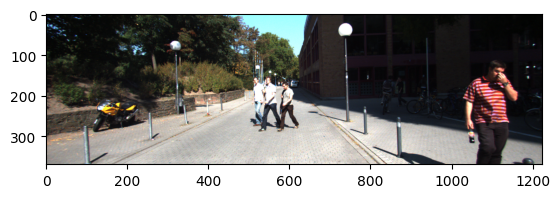

In [10]:
# Pre-processing and post-processing constants 
IMG_SCALE  = 1./255
IMG_MEAN = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
IMG_STD = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))

def prepare_img(img):
    return (img * IMG_SCALE - IMG_MEAN) / IMG_STD

CMAP = np.load('cmap_nyud.npy')
NUM_CLASSES = 40

images_files = glob.glob('data/*.png')
idx = np.random.randint(0, len(images_files))

img_path = images_files[idx]
img = np.array(Image.open(img_path))
plt.imshow(img)
plt.show()

Run the image through the model

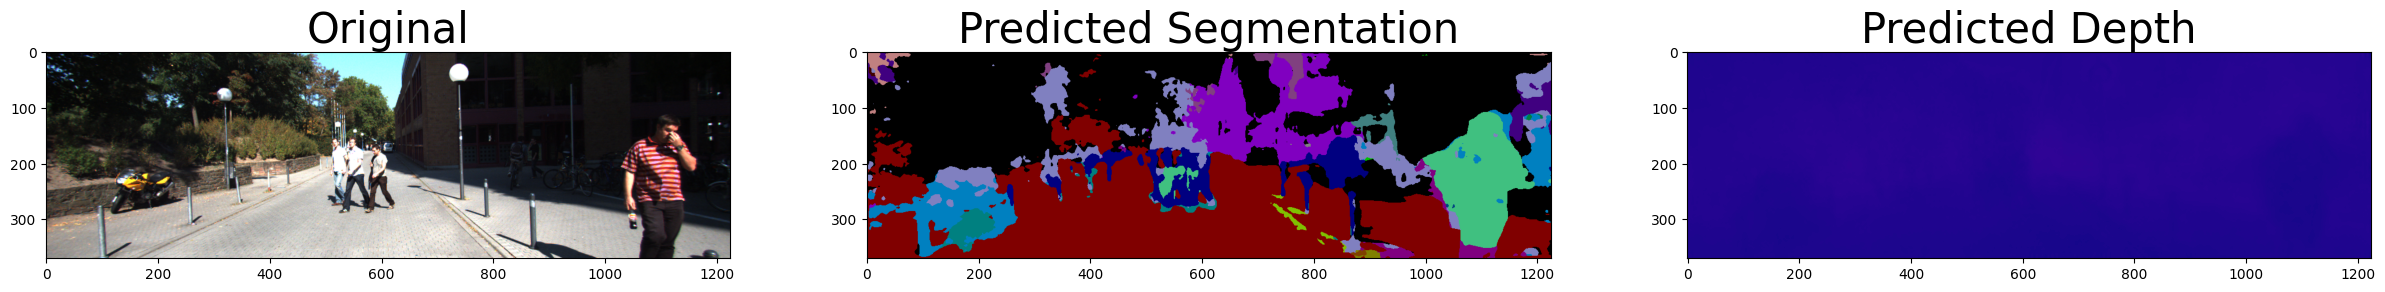

In [11]:
def pipeline(img):
    with torch.no_grad():
        img_var = Variable(torch.from_numpy(prepare_img(img).transpose(2, 0, 1)[None]), requires_grad=False).float()
        if torch.cuda.is_available():
            img_var = img_var.cuda()
        segm, depth = hydranet(img_var)
        segm = cv2.resize(segm[0, :NUM_CLASSES].cpu().data.numpy().transpose(1, 2, 0),
                        img.shape[:2][::-1],
                        interpolation=cv2.INTER_CUBIC)
        depth = cv2.resize(depth[0, 0].cpu().data.numpy(),
                        img.shape[:2][::-1],
                        interpolation=cv2.INTER_CUBIC)
        segm = CMAP[segm.argmax(axis=2)].astype(np.uint8)
        depth = np.abs(depth)
        return depth, segm
    
depth, segm = pipeline(img)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,20))
ax1.imshow(img)
ax1.set_title('Original', fontsize=30)
ax2.imshow(segm)
ax2.set_title('Predicted Segmentation', fontsize=30)
ax3.imshow(depth, cmap="plasma", vmin=0, vmax=80)
ax3.set_title("Predicted Depth", fontsize=30)
plt.show()

Let's normalize the depth and visualize it.

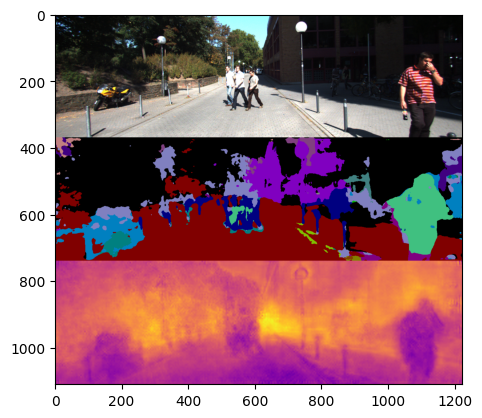

In [12]:
def depth_to_rgb(depth):
    normalizer = co.Normalize()
    mapper = cm.ScalarMappable(norm=normalizer, cmap='plasma')
    colormapped_im = (mapper.to_rgba(depth)[:, :, :3] * 255).astype(np.uint8)
    return colormapped_im

depth_rgb = depth_to_rgb(depth)

new_img = np.vstack((img, segm, depth_rgb))
plt.imshow(new_img)
plt.show()

Let's see how it looks as a video.

In [13]:
video_files = sorted(glob.glob("data/*.png"))

# Set the Model to Eval on GPU
if torch.cuda.is_available():
    _ = hydranet.cuda()
_ = hydranet.eval()

# Run the pipeline
result_video = []
for idx, img_path in enumerate(video_files):
    image = np.array(Image.open(img_path))
    h, w, _ = image.shape 
    depth, seg = pipeline(image)
    result_video.append(cv2.cvtColor(cv2.vconcat([image, seg, depth_to_rgb(depth)]), cv2.COLOR_BGR2RGB))

if not os.path.exists('output'):
    os.makedirs('output')

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output/out.mp4', fourcc, 15, (w,3*h))

for i in range(len(result_video)):
    out.write(result_video[i])
out.release()

TODO: insert video at output/out.mp4

# 4 — Add a Second Depth Head
Using the transfer learning techniques from the beginning of this notebook we can add another head to the existing decoder and instead of defining and creating the class with a new forward method we can just define it right here.

In [14]:
conv1 = nn.Conv2d(256,128,1,1)
conv2 = nn.Conv2d(128,64,3,1)
conv3 = nn.Conv2d(64,1,3,1)
decoder.net2 = nn.DataParallel(nn.Sequential(conv1, nn.ReLU6(inplace=True), conv2, nn.ReLU6(inplace=True), conv3, nn.ReLU6(inplace=True)))

In [15]:
def extended_forward(self, xs):
        xs = list(reversed(xs))
        for idx, (conv, x) in enumerate(zip(self.stem_convs, xs)):
            xs[idx] = conv(x)

        # Collapse layers
        c_xs = [sum([xs[idx] for idx in make_list(c_idx)]) for c_idx in self.collapse_ind ]

        for idx, (crp, x) in enumerate(zip(self.crp_blocks, c_xs)):
            if idx == 0:
                y = self.relu(x)
            else:
                y = self.relu(x + y)
            y = crp(y)
            if idx < (len(c_xs) - 1):
                y = self.adapt_convs[idx](y)
                y = F.interpolate(
                    y,
                    size=c_xs[idx + 1].size()[2:],
                    mode="bilinear",
                    align_corners=True,
                )

        outs = []
        for head in self.heads:
            outs.append(head(y))

        outs.append(self.net2(y))
        
        return outs

# Sadly this didn't work
#decoder.forward = extended_forward

# So we had to do some gymnastics
bound_method = extended_forward.__get__(decoder, decoder.__class__)
setattr(decoder, 'forward', bound_method)

wow


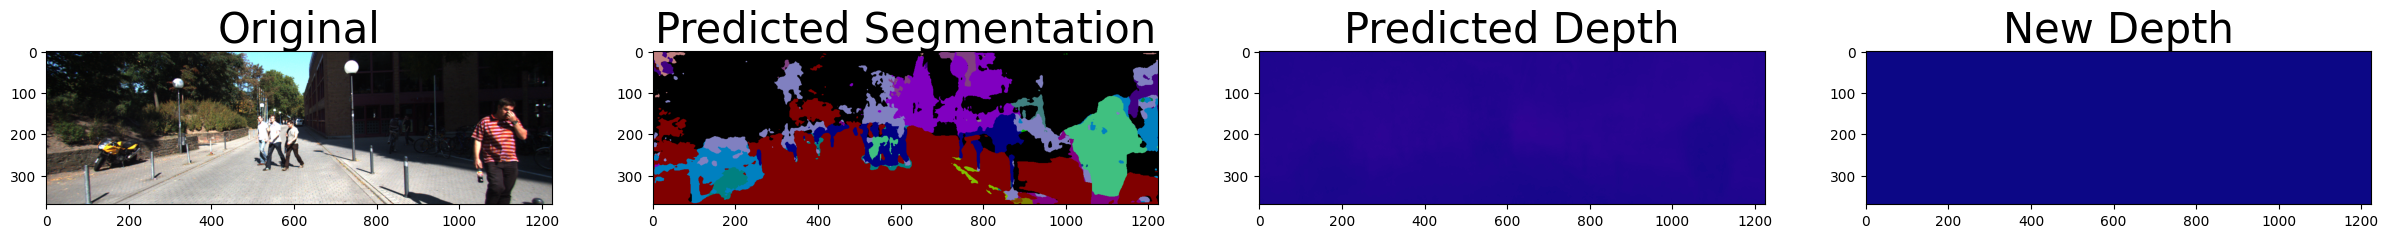

In [16]:
def pipeline(img):
    with torch.no_grad():
        img_var = Variable(torch.from_numpy(prepare_img(img).transpose(2, 0, 1)[None]), requires_grad=False).float()
        if torch.cuda.is_available():
            img_var = img_var.cuda()
        segm, depth1, depth2 = hydranet(img_var)
        segm = cv2.resize(segm[0, :NUM_CLASSES].cpu().data.numpy().transpose(1, 2, 0),
                        img.shape[:2][::-1],
                        interpolation=cv2.INTER_CUBIC)
        depth1 = cv2.resize(depth1[0, 0].cpu().data.numpy(),
                        img.shape[:2][::-1],
                        interpolation=cv2.INTER_CUBIC)
        depth2 = cv2.resize(depth2[0, 0].cpu().data.numpy(),
                        img.shape[:2][::-1],
                        interpolation=cv2.INTER_CUBIC)
        segm = CMAP[segm.argmax(axis=2)].astype(np.uint8)
        depth1 = np.abs(depth1)
        depth2 = np.abs(depth2)
        return depth1, segm, depth2
    
depth1, segm, depth2 = pipeline(img)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,20))
ax1.imshow(img)
ax1.set_title('Original', fontsize=30)
ax2.imshow(segm)
ax2.set_title('Predicted Segmentation', fontsize=30)
ax3.imshow(depth1, cmap="plasma", vmin=0, vmax=80)
ax3.set_title("Predicted Depth", fontsize=30)
ax4.imshow(depth2, cmap="plasma", vmin=0, vmax=80)
ax4.set_title("New Depth", fontsize=30)
plt.show()

Let's normalize the depth again

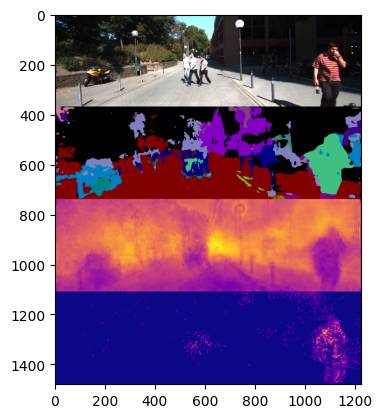

In [17]:
def depth_to_rgb(depth):
    normalizer = co.Normalize()
    mapper = cm.ScalarMappable(norm=normalizer, cmap='plasma')
    colormapped_im = (mapper.to_rgba(depth)[:, :, :3] * 255).astype(np.uint8)
    return colormapped_im

new_img = np.vstack((img, segm, depth_to_rgb(depth1), depth_to_rgb(depth2)))
plt.imshow(new_img)
plt.show()